In this file, we first load the fMRI data for each voxel we want to prediction.
- We then calculate a text description for each voxel, which we hope will corresponding to a semantic concept
- Next, we visualize these concepts and select a couple best ones
- We visualize the best ones
- We then validate that the best ones are spatially close together

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from tqdm import tqdm
import pickle as pkl
import scipy
import random
import os
from os.path import join as oj
import cortex # brain viz library
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer
from iprompt import suffix
from iprompt.data_utils import neuro
import pandas as pd
import string
from collections import defaultdict
from matplotlib.pyplot import cm
import dvu
from datasets import Dataset
dvu.set_style()
from copy import deepcopy

# initial set up
checkpoint = 'EleutherAI/gpt-neox-20b'
save_dir = f'/home/chansingh/results_fast/fmri/{checkpoint.replace("/", "___")}/logits'
# save_dir = f'/home/chansingh/mntv1/fmri/20B/logits_{checkpoint}'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token
word_lists = neuro.fetch_data(n_words=15)

**merge logits**

In [8]:
seeds = range(1, 3)
for seed in seeds:
    if seed == 1: 
        all_logits = pkl.load(open(oj(save_dir, f'all_logits_seed={seed}.pkl'), 'rb'))
    else:
        all_logits += pkl.load(open(oj(save_dir, f'all_logits_seed={seed}.pkl'), 'rb'))
all_logits /= len(seeds)
pkl.dump(all_logits, open(oj(save_dir, f'all_logits_avg.pkl'), 'wb'))

# Decode top tokens

In [2]:
all_logits = pkl.load(open(oj(save_dir, 'all_logits_avg.pkl'), 'rb'))
STOPWORDS = suffix.get_stopwords()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chansingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def get_top_decoded_tokens(next_token_logits, top_k=20):
    # decode top tokens
    top_k_inds = np.arange(next_token_logits.size)
    top_k_inds = top_k_inds[np.argsort(next_token_logits[top_k_inds])][::-1]
    top_decoded_tokens = np.array(
        [tokenizer.decode(ind) for ind in top_k_inds])

    # remove nonsense
    STOPWORDS_PHRASING = ['called', 'simply', 'either', 'probably']
    STOPWORDS_EXTRA = ['something', 'things', 'type', 'object', 'objects']    
    disallowed_idxs = np.array([
        # general
        s.isspace() # space
        or all(c in string.punctuation for c in s.strip()) # punc
        or len(s) <= 3 # length
        or s == s.upper() # all CAPS tokens

        # keywords
        or s.lower().strip() in STOPWORDS # stopwords 
        or s.lower().strip() in STOPWORDS_PHRASING # stopwords  
        or s.lower().strip() in STOPWORDS_EXTRA # stopwords  

        # check if it is one of the inputs
        or s.strip().lower() in word_lists[0] # not one of the inputs
        or s.strip().lower() + 's' in word_lists[0] # plural not in inputs
        or s.strip().lower() in [word + 's' for word in word_lists[0]] # singular not in inputs
        for s in top_decoded_tokens],
        dtype=bool)
    top_k_inds = top_k_inds[~disallowed_idxs]
    top_decoded_tokens = top_decoded_tokens[~disallowed_idxs]
    return top_decoded_tokens[:top_k]

# Let's look at some example
for i in range(5):
    # print(make_prompt_from_word_list(word_lists[i]))
    print(', '.join(word_lists[i]))
    print('\t' + ', '.join(get_top_decoded_tokens(all_logits[i])))
    print()

sheet, edges, diameter, strips, cardboard, copper, steel, colored, coloured, leaf, wire, cap, paper, shaped, tin
	 metal,  material,  shape,  container,  thin,  metallic,  metals,  Metal,  materials,  flat,  named,  thing,  packaging,  containers,  stuff,  metall,  category,  shapes,  rectangular,  Material

lighter, vertical, diameter, edges, horizontal, cap, rear, underneath, sheet, mounted, circular, cylinder, plate, mm, yellow
	 shape,  cylinder,  plate,  circular,  container,  size,  measurement,  circle,  surface,  cylindrical,  part,  geometric,  light,  material,  vertical,  lighting,  thing,  round,  flat,  geometrical

cap, ink, lighter, colored, leather, strips, sheet, plastic, cardboard, powder, copper, leaf, thicker, rubber, cloth
	 material,  plastic,  clothing,  fabric,  plastics,  materials,  clothes,  stuff,  substance,  thing,  container,  rubber,  texture,  color,  text,  textile,  household,  cloth,  thin,  product

paper, cap, colored, printed, sheet, orange, yello

In [5]:
# look at recurring words over the top voxels
n_top_voxels = 20
decoded_token_counts = defaultdict(int)
print('looping over', n_top_voxels, 'voxels')
for i in tqdm(range(n_top_voxels)):
    top_decoded_tokens = get_top_decoded_tokens(all_logits[i], top_k=20)
    for tok in top_decoded_tokens:
        decoded_token_counts[tok] += 1
for k, v in sorted(decoded_token_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(repr(k), v)

looping over 20 voxels


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]

' material' 17
' clothing' 11
' fabric' 10
' color' 10
' text' 10
' clothes' 9
' textile' 9
' materials' 8
' cloth' 8
' garment' 8


In [6]:
# select a couple
concepts = [' material', ' color', ' fabric', ' text', ' surface']
concept_ids = [tokenizer.encode(concepts[i])[0] for i in range(len(concepts))]
scores_list = [all_logits[:, concept_ids[i]] for i in range(len(concepts))]
# all_probs = scipy.special.softmax(all_logits, axis=-1)
# probs_list = [all_probs[:, concept_ids[i]] for i in range(len(concepts))]

# Show that scores are spatially clustered

In [ ]:
meta = neuro.fetch_meta()
def deltas(idx, delta=1, dim_size=100):
    return max(0, idx - delta), min(idx + delta, dim_size)


def compute_avg_std(scores, meta):
    s = np.zeros(meta['mask'].shape)
    s[meta['mask'] > 0] = neuro.remap_scores_best_to_scores_all(
        scores, meta['corrsort'])
    num_blocks = 0
    stds = []
    for x in range(s.shape[0]):
        for y in range(s.shape[1]):
            for z in range(s.shape[2]):
                if s[x, y, z]:
                    xmin, xmax = deltas(x, dim_size=s.shape[0])
                    ymin, ymax = deltas(y, dim_size=s.shape[1])
                    zmin, zmax = deltas(z, dim_size=s.shape[2])
                    
                    neighbors_mask = meta['mask'][xmin: xmax, ymin: ymax, zmin: zmax]
                    # print(neighbors_mask.sum())
                    if neighbors_mask.sum() > 2:
                        num_blocks += 1
                        neighbors = s[xmin: xmax, ymin: ymax, zmin: zmax]
                        neighbors = neighbors[neighbors > 0]
                        # print(neighbors_mask.sum(), (neighbors>0).sum()) # note, neighbors has more zeros than mask, only 10k out of the total 310k
                        # print(neighbors)
                        stds.append(np.std(neighbors))
    return np.mean(stds)

# metric: variance in value among neighbors (actual vs randomized)
num_rand_repeats = 5
llm_avg = []
rand_avg = []
rand_std = []
for i, concept_id in enumerate(concept_ids):
    scores = deepcopy(all_logits[:, concept_id].squeeze())
    llm_avg.append(compute_avg_std(scores, meta))
    rands = []
    for i in range(num_rand_repeats):
        np.random.shuffle(scores)
        rands.append(compute_avg_std(scores, meta))
    rand_avg.append(np.mean(rands))
    rand_std.append(np.std(rands) / np.sqrt(len(rands)))


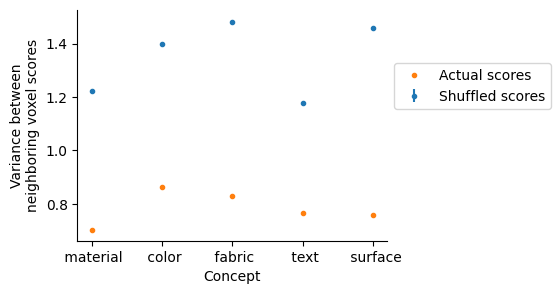

In [20]:
plt.figure(figsize=(4, 3))
xticks = np.arange(len(concept_ids))
plt.errorbar(xticks, rand_avg, yerr=rand_std, ls='none', marker='.', label='Shuffled scores')
plt.plot(xticks, llm_avg, ls='none', marker='.', label='Actual scores')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(xticks, labels=concepts)
plt.ylabel('Variance between\nneighboring voxel scores')
plt.xlabel('Concept')
plt.legend(bbox_to_anchor=(1, 0.8))
plt.savefig('results/fmri/concepts_clustered.pdf', bbox_inches='tight')

# Visualize scores

In [ ]:
import cortex
meta = neuro.fetch_meta()

def flatmap_quickshow(scores, mask, corrsort,
                      with_rois=True, with_labels=True,
                      vmin=None, vmax=None, cmap=cm.hot):
    """
    rois & labels require inkscape

    # there's also a fancy web version
    # cortex.webshow(corrvol, port=8889, open_browser=False)
    """
    if vmin is None:
        vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    scores_reshaped = neuro.remap_scores_best_to_scores_all(scores, corrsort)
    corrvol = cortex.Volume(scores_reshaped, "S1", "fullhead",
                            mask=mask, vmin=vmin, vmax=vmax, cmap=cmap)
    cortex.quickshow(corrvol, with_rois=with_rois,
                     with_labels=with_labels, colorbar_location='right')

def flatmap_quickshow_2d(scores1, scores2, mask, corrsort,
                      with_rois=True, with_labels=True,
                      cmap=cm.hot):
    """
    rois & labels require inkscape

    # there's also a fancy web version
    # cortex.webshow(corrvol, port=8889, open_browser=False)
    """
    s1 = np.zeros(mask.shape)
    s1[mask > 0] = neuro.remap_scores_best_to_scores_all(scores1, corrsort)


    s2 = np.zeros(mask.shape)
    s2[mask > 0] = neuro.remap_scores_best_to_scores_all(scores2, corrsort)
    # scores_reshaped = neuro.remap_scores_best_to_scores_all(scores, corrsort)
    # corrvol = cortex.Volume(scores_reshaped, "S1", "fullhead",
    #                         mask=mask, vmin=vmin, vmax=vmax, cmap=cmap)

    vol_data = cortex.Volume2D(s1, s2, "S1", "fullhead",
                           mask=meta['mask'],
                           vmin=np.min(s1), vmax=np.max(s1),
                           vmin2=np.min(s2), vmax2=np.max(s2),
                        #    cmap='BuOr_2D'
                            cmap='PU_RdBu_covar',
                           )
    cortex.quickshow(vol_data, with_colorbar=True, colorbar_location='right')
    # cortex.quickshow(corrvol, with_rois=with_rois,
                    #  with_labels=with_labels, colorbar_location='right')
    # print(plt.gca().xticks([0, 3]))

flatmap_quickshow_2d(scores_list[0], scores_list[1], meta['mask'], meta['corrsort'], )
plt.savefig('flatmap.pdf')
# note x-axis of 2d colorbar represents the first scores
# flatmap_quickshow_2d(probs_list[0], probs_list[1], meta['mask'], meta['corrsort'])

In [ ]:
flatmap_quickshow(scores_list[0] - scores_list[1], meta['mask'], meta['corrsort'],
                  with_rois=True, with_labels=True)
plt.show()

In [ ]:
scores = scores_list[1]
flatmap_quickshow(scores, meta['mask'], meta['corrsort'],
                  with_rois=True, with_labels=True, vmin=scores.min(), vmax=scores.max())